In [1]:
import pprint

# Data libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Classifiers 
from lightgbm import LGBMClassifier
import lightgbm

# Analysis libs
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc
from sklearn.model_selection import StratifiedKFold

In [2]:
malware_data_filepath = '../datasets/Obfuscated/Obfuscated-MalMem2022_edited.csv'
malware_data = pd.read_csv(malware_data_filepath)

In [3]:
X_drop_columns = ['Class', 
                'Category', 
                'svcscan.interactive_process_services', 
                'handles.nport', 
                'modules.nmodules',
                'pslist.nprocs64bit', 
                'callbacks.ngeneric']
X = malware_data.drop(columns=X_drop_columns)

y_column = malware_data.Class
class_le = LabelEncoder()
y = class_le.fit_transform(y_column)

In [4]:
X.shape

(58596, 50)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X ,y, test_size=0.3, random_state=0, stratify=y)

In [6]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (41017, 50)
y_train shape: (41017,)
X_test shape: (17579, 50)
y_test shape: (17579,)


In [7]:
# lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
lgbm = LGBMClassifier(n_estimators=X.shape[1], learning_rate=1.0)
clf = lgbm.fit(X_train, y_train)
y_pred_test = clf.predict(X_test)
y_pred_train = clf.predict(X_train)

print('Train score: {0:0.4f}'.format(accuracy_score(y_train, y_pred_train)))
print('Test accuracy score: {0:0.4f}'.format(accuracy_score(y_test, y_pred_test)))

[LightGBM] [Info] Number of positive: 20509, number of negative: 20508
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7600
[LightGBM] [Info] Number of data points in the train set: 41017, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500012 -> initscore=0.000049
[LightGBM] [Info] Start training from score 0.000049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

In [8]:
print(f"Accuracy score: {accuracy_score(y_test, y_pred_test)}")
print(f"Precision score: {precision_score(y_test, y_pred_test)}")
print(f"Recall score: {recall_score(y_test, y_pred_test)}")
print(f"F-1 score: {f1_score(y_test, y_pred_test)}")

Accuracy score: 0.9999431139427726
Precision score: 0.9998862343572241
Recall score: 1.0
F-1 score: 0.9999431139427726


In [8]:
cm = confusion_matrix(y_test, y_pred_test, labels=clf.classes_)
cm

array([[8789,    1],
       [   0, 8789]])

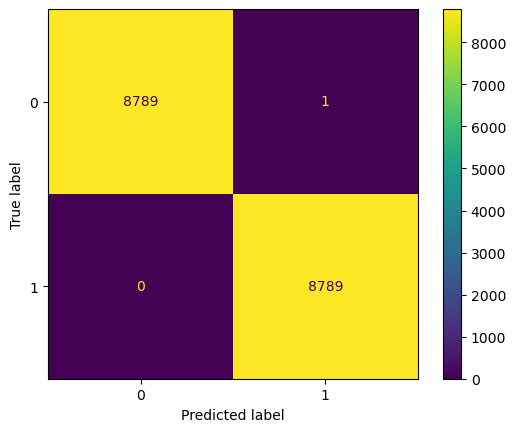

In [9]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

In [10]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8790
           1       1.00      1.00      1.00      8789

    accuracy                           1.00     17579
   macro avg       1.00      1.00      1.00     17579
weighted avg       1.00      1.00      1.00     17579



In [11]:
train_data = lightgbm.Dataset(X_train, label=y_train)

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 4,
    'metric': 'multi_logloss',
    'verbose': -1
}

# Perform cross-validation
cv_results = lightgbm.cv(params, train_data, num_boost_round=100, nfold=10, stratified=True)

print(f"Average Log Loss: {cv_results['valid multi_logloss-mean'][-1]:.4f} +/- {cv_results['valid multi_logloss-stdv'][-1]:.4f}")


Average Log Loss: 0.0012 +/- 0.0024


[LightGBM] [Info] Number of positive: 26368, number of negative: 26368
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002352 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7680
[LightGBM] [Info] Number of data points in the train set: 52736, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

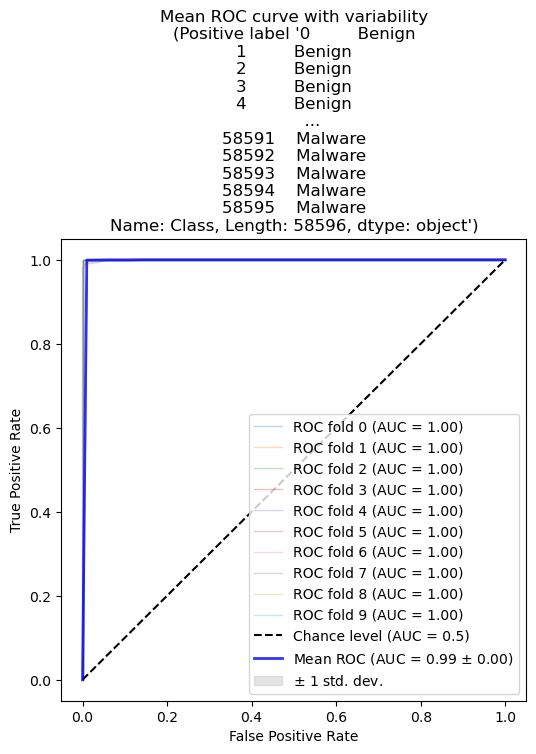

In [12]:
n_splits = 10
cv = StratifiedKFold(n_splits=n_splits)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots(figsize=(6, 6))
for fold, (train, test) in enumerate(cv.split(X, y)):
        lgbm.fit(X.iloc[train], y[train])
        viz = RocCurveDisplay.from_estimator(
                lgbm,
                X.iloc[test],
                y[test],
                name=f"ROC fold {fold}",
                alpha=0.3,
                lw=1,
                ax=ax,
                plot_chance_level=(fold == n_splits - 1),
        )
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
        mean_fpr,
        mean_tpr,
        color="b",
        label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
        lw=2,
        alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
        mean_fpr,
        tprs_lower,
        tprs_upper,
        color="grey",
        alpha=0.2,
        label=r"$\pm$ 1 std. dev.",
)

ax.set(
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"Mean ROC curve with variability\n(Positive label '{malware_data.Class}')",
)
ax.legend(loc="lower right")
plt.show()